# Question 2

In this question we will:
- Implement the vector median filter for colour images.
- Apply the vector median filter to a small dataset and establish a baseline performance meteric.
- Try to design a denoising pipeline that outperforms using only the vector median filter.   

# Step 1: Implement the vector median filter for colour images.

## Instructions

- Write a function that implements the vector median filter.  Details on the vector median filter can be found in Topic 4 of the lecture notes and implementation suggestions can be found in Section 2 of the asignment PDF.  
- The parameters to your function should be the input image `I`, and the `radius` of the square neighbourhood, e.g. radius 1 = 3x3 filter, radius 2 = 5x5 filter, etc.
- Your function should accept images of dtype `uint8` or `float64` (other types may be rejected if you wish).    It is easiest if you work with the image as data type `float64`.   If the input image is of type `uint8`, it is suggested that you convert it to dtype `float64`, construct the output image also as type `float64` and then convert it back to `uint8` before returning it.  In any case, the output image returned should be the same dtype as the input image.

In [23]:

def vector_median(I, radius):
    
    I_2 = skutil.img_as_float(I)
    rows, cols, chan = I_2.shape
    
    output = np.zeros_like(I_2)
    
    # Neighborhood size (2 * radius + 1) x (2 * radius + 1)
    n_size = 2 * radius + 1
    
    for r in range(radius, rows - radius):
        for c in range(radius, cols - radius):
            Iwindow = I_2[r - radius:r + radius + 1, c - radius:c + radius + 1, :]
            

            colours = np.reshape(Iwindow, (n_size * n_size, chan))

            Y = np.tile(colours[:, np.newaxis, :], (1, n_size * n_size, 1))
            
            X = np.tile(colours[np.newaxis, :, :], (n_size * n_size, 1, 1))
            
            man_dist = np.sum(np.abs(X - Y), axis=(1, 2))

            min_index = np.argmin(man_dist)
            median_color = colours[min_index, :]
            
            output[r, c, :] = median_color
 
        output = skutil.img_as_ubyte(output)
    
    return output

# Step 2a: Establish a Baseline

## Instructions

- Determine the PSNR and SSIM of all of the noisy images by comparing them to their noiseless versions -- store these in a list.  
    - Use the same method to read the images files as in question 1, but read them from the `images/noisy` directory and the `images/noiseless` directory as needed.
- Filter each noisy image with a 3x3 vector median filter and compute the PSNR and SSIM of all of the filtered noisy images (by comparing them to the noiseless images) -- store these in a list.   
    - As with question 1, to save time we recommend you develop and debug your programs using only the first three to five images in file_list, and run it on the complete list when you're done. 
- The noiseless images are provided so you can compute PSNR and SSIM.  See functions `skmetrics.peak_signal_noise_ratio()` and `skmetrics.structural_similarity()`.  You'll need the `channel_axis=2` argument for `structural_similarity()`.  This indicates to the function that the it is the 3rd dimension of the 3D arrays that index the R, G and B channels.

_Hint: This step requires doing a few seemingly different things, but it's actually easier to do them all at once in the same loop._



In [40]:
# Some modules you might need.

import skimage.io as io
import os as os
import skimage.metrics as skmetrics
import skimage.util as skutil
import numpy as np
import pandas as pd

files = pd.read_csv("/u1/cmpt487-819/data/asn1/images.csv", header=None)
noiseless_dir = "/u1/cmpt487-819/data/asn1/images/noiseless/"
noisy_dir = "/u1/cmpt487-819/data/asn1/images/noisy/"

file_list = files[0].tolist()

psnr_noisy_list = []
ssim_noisy_list = []
psnr_filtered_list = []
ssim_filtered_list = []

counter = 0
for filename in file_list:
    counter+=1

    noiseless_image = io.imread(os.path.join(noiseless_dir, filename))
    noisy_image = io.imread(os.path.join(noisy_dir, filename))
    
    noiseless_image_float = skutil.img_as_float(noiseless_image)
    noisy_image_float = skutil.img_as_float(noisy_image)
    
    filtered_image = vector_median(noisy_image_float, radius=1)

    psnr_noisy = skmetrics.peak_signal_noise_ratio(noiseless_image_float, noisy_image_float)
    ssim_noisy = skmetrics.structural_similarity(noiseless_image_float, noisy_image_float, data_range=1.0, channel_axis=2)

    psnr_filtered = skmetrics.peak_signal_noise_ratio(noiseless_image_float, filtered_image)
    ssim_filtered = skmetrics.structural_similarity(noiseless_image_float, filtered_image, data_range=1.0, channel_axis=2)
    
    psnr_noisy_list.append(psnr_noisy)
    ssim_noisy_list.append(ssim_noisy)
    psnr_filtered_list.append(psnr_filtered)
    ssim_filtered_list.append(ssim_filtered)
    print(counter, end ='\r')

# Step 2b: Compute average baseline metrics.

## Instructions

Compute the average PSNR and SSIM for the unfiltered noisy images (take the PSNR and SSIM measures for each image and average them).  Do the same for the median-filtered noisy images.  Plot a bar graph showing the two mean PSNR values and another showing the two mean SSIM values before and after filtering (see assignment description for sample output).

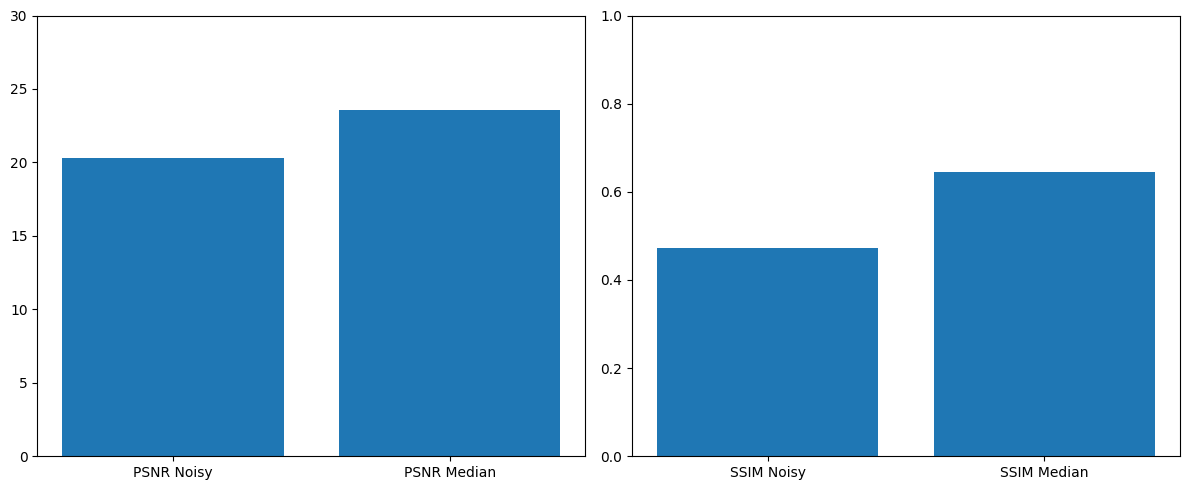

In [41]:
# some modules you might need.

import matplotlib.pyplot as plt
import numpy as np

avg_psnr_noisy = np.mean(psnr_noisy_list)
avg_ssim_noisy = np.mean(ssim_noisy_list)
avg_psnr_filtered = np.mean(psnr_filtered_list)
avg_ssim_filtered = np.mean(ssim_filtered_list)

plt.subplots(1, 2, figsize=(12, 5))

plt.subplot(1, 2, 1)
psnr_values = [avg_psnr_noisy, avg_psnr_filtered]
plt.bar(['PSNR Noisy', 'PSNR Median'], psnr_values)
plt.ylim(0, 30) 

plt.subplot(1, 2, 2)
ssim_values = [avg_ssim_noisy, avg_ssim_filtered]
plt.bar(['SSIM Noisy', 'SSIM Median'], ssim_values)
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()

# Step 3:  See if you can do better!

Find a better way to denoise the images.  Compute the mean PSNR and SSIM for your denoising method.   Replot the graphs in the previous step with the new results added.

_You can use any functions in the python libraries to help you (numpy, scipy, skimage, etc.) but you cannot bring in code from external sources._


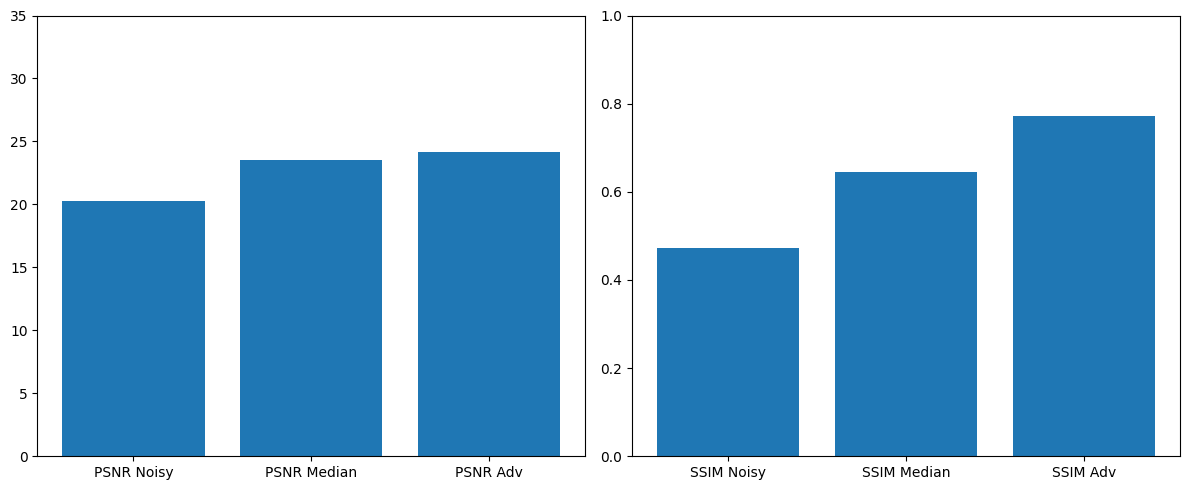

In [51]:
# Write your de-noising method here.

from skimage.restoration import denoise_nl_means, estimate_sigma

def advanced_denoising(image):
    #remove both types of noise
    median_filtered_image = vector_median(image, radius = 1)
    
    sigma_est = np.mean(estimate_sigma(median_filtered_image, channel_axis=2))
    denoised_image = denoise_nl_means(median_filtered_image, h=sigma_est,channel_axis=2)
    
    return denoised_image

psnr_adv_list = []
ssim_adv_list = []
counter = 0
for filename in file_list[0:100]:
    counter +=1
    noiseless_image = io.imread(os.path.join(noiseless_dir, filename))
    noisy_image = io.imread(os.path.join(noisy_dir, filename))
    
    noiseless_image_float = skutil.img_as_float(noiseless_image)
    noisy_image_float = skutil.img_as_float(noisy_image)
    
    adv_denoised = advanced_denoising(noisy_image_float)
    
    psnr_adv = skmetrics.peak_signal_noise_ratio(noiseless_image_float, adv_denoised)
    ssim_adv = skmetrics.structural_similarity(noiseless_image_float, adv_denoised, data_range=1.0, channel_axis=2)
    
    psnr_adv_list.append(psnr_adv)
    ssim_adv_list.append(ssim_adv)
    
    print(counter, end='\r')

avg_psnr_adv = np.mean(psnr_adv_list)
avg_ssim_adv = np.mean(ssim_adv_list)


plt.subplots(1, 2, figsize=(12, 5))

# PSNR plot
plt.subplot(1, 2, 1)
psnr_values = [avg_psnr_noisy, avg_psnr_filtered, avg_psnr_adv]
plt.bar(['PSNR Noisy', 'PSNR Median','PSNR Adv'], psnr_values)
plt.ylim(0, 35) 

# SSIM plot
plt.subplot(1, 2, 2)
ssim_values = [avg_ssim_noisy, avg_ssim_filtered, avg_ssim_adv]
plt.bar(['SSIM Noisy', 'SSIM Median','SSIM Adv'], ssim_values)
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()    